# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [3]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)  

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["validator_profit"] = df["av_validator_reward"] * df["token_price"] - 200.0
l = [np.log(2) / (i * 365) for i in [6.0,  4.0, 2.0]]
d = {
    l[0]: "6yrs half-life",
    l[1]: "4yrs half-life",
    l[2]: "2yrs half-life",
}
df['decay_rate'] = df['staking_rewards_vesting_decay_rate'].map(d)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " max_rate=" + df["release_rate_max"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

10643400

In [4]:
base_df = df[df["token_scenario"]=="base"]
combined_df = df[(df["staking_scenario"]==df["usage_scenario"]) & (df["staking_scenario"]==df["token_scenario"])]
combined_df["combined_scenario"] = combined_df["staking_scenario"]

## 3. Reward sources

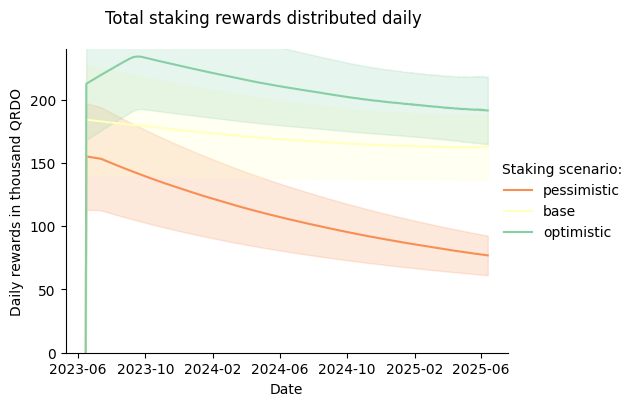

In [5]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

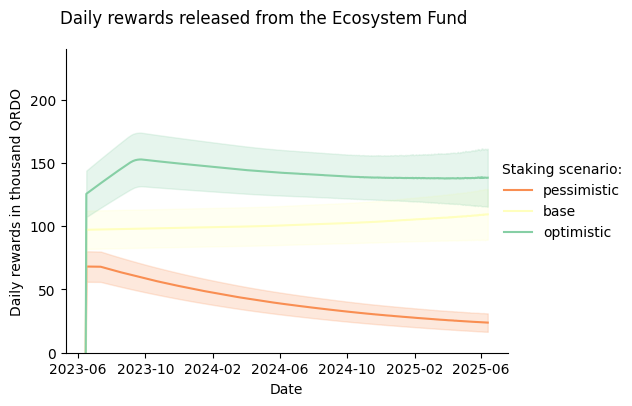

In [6]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

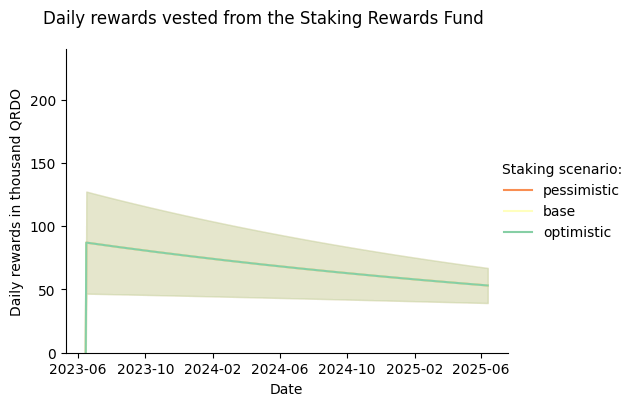

In [7]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Staking scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

### 4.1 Staker APR

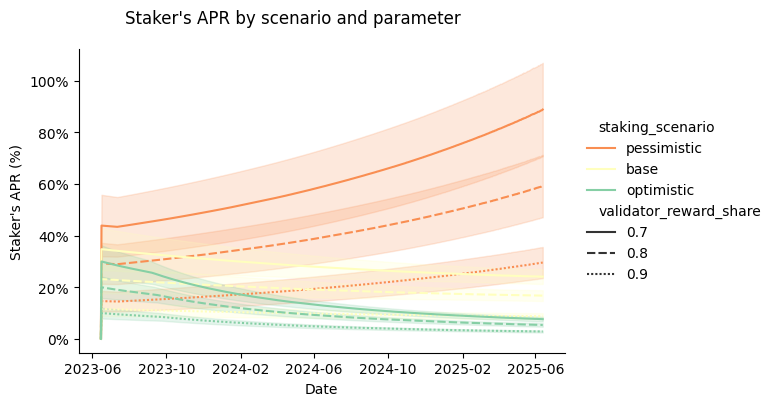

In [8]:
g = sns.relplot(data=df, x="date", y="apr", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [9]:
df.groupby(["staking_scenario", "validator_reward_share"])["apr"].mean()

staking_scenario  validator_reward_share
base              0.7                       0.282876
                  0.8                       0.193017
                  0.9                       0.098930
optimistic        0.7                       0.150241
                  0.8                       0.103726
                  0.9                       0.053805
pessimistic       0.7                       0.610659
                  0.8                       0.407115
                  0.9                       0.203554
Name: apr, dtype: float64

### 4.2 Validator profit

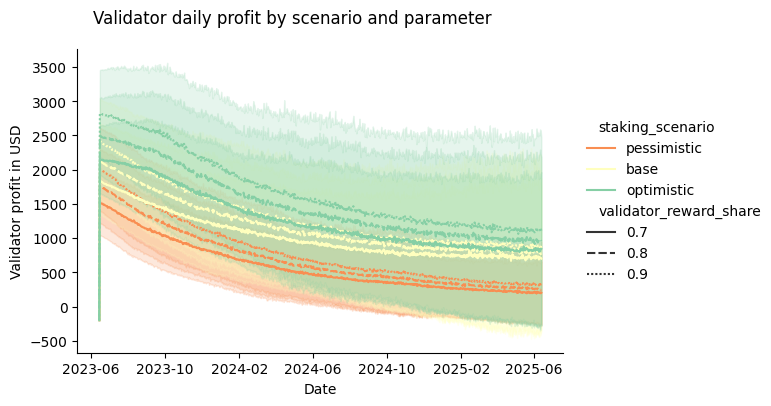

In [10]:
g = sns.relplot(data=df, x="date", y="validator_profit", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [11]:
df.groupby(["staking_scenario", "validator_reward_share"])["validator_profit"].mean()

staking_scenario  validator_reward_share
base              0.7                       1023.217593
                  0.8                       1168.841088
                  0.9                       1306.814008
optimistic        0.7                       1279.617102
                  0.8                       1489.137183
                  0.9                       1697.057491
pessimistic       0.7                        582.986758
                  0.8                        694.242759
                  0.9                        806.405188
Name: validator_profit, dtype: float64

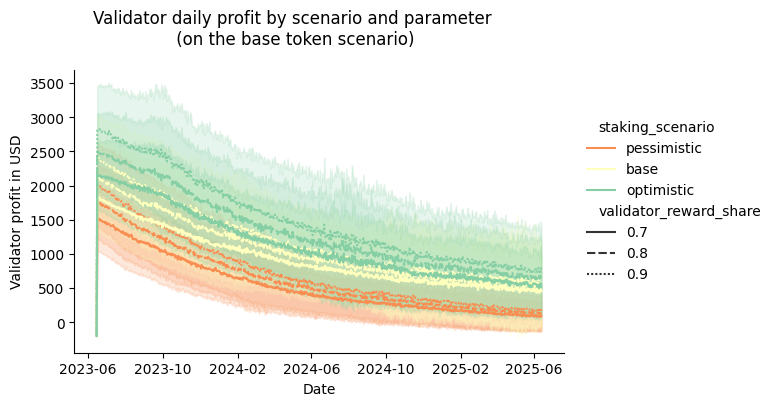

In [12]:
g = sns.relplot(data=base_df, x="date", y="validator_profit", style="validator_reward_share", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter\n (on the base token scenario)")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [13]:
base_df.groupby(["iteration","staking_scenario", "validator_reward_share"])["validator_profit"].mean().tail(6)

iteration  staking_scenario  validator_reward_share
729        optimistic        0.7                       523.615870
                             0.8                       644.276248
                             0.9                       771.462983
           pessimistic       0.7                        95.551558
                             0.8                       136.039414
                             0.9                       190.807826
Name: validator_profit, dtype: float64

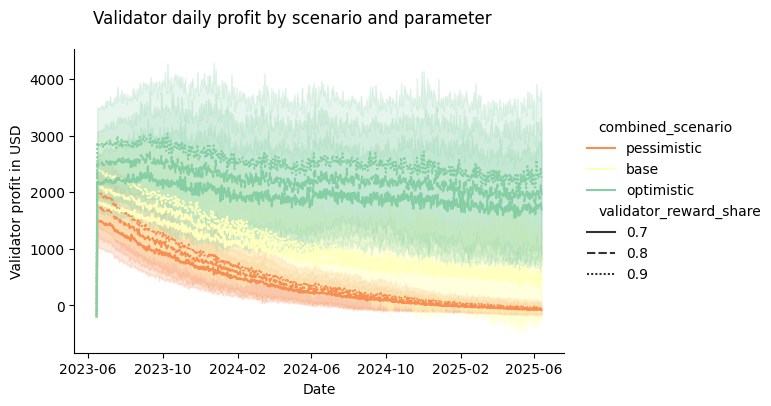

In [14]:
g = sns.relplot(data=combined_df, x="date", y="validator_profit", style="validator_reward_share", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [15]:
combined_df.groupby(["combined_scenario", "validator_reward_share"])["validator_profit"].mean()

combined_scenario  validator_reward_share
base               0.7                        922.408427
                   0.8                       1059.309364
                   0.9                       1186.303284
optimistic         0.7                       1933.320110
                   0.8                       2227.978926
                   0.9                       2533.470369
pessimistic        0.7                        370.136821
                   0.8                        451.362654
                   0.9                        533.350722
Name: validator_profit, dtype: float64

## 5. Parameter analysis - vesting decay rate

In [16]:
vest_df = df[df["validator_reward_share"]==0.9]
vest_comb_df = combined_df[combined_df["validator_reward_share"]==0.9]

### 5.1 Staker APR

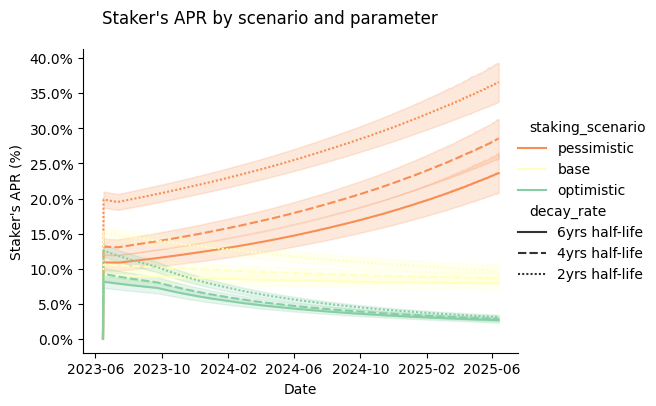

In [17]:
g = sns.relplot(data=vest_df, x="date", y="apr", style="decay_rate", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Staker's APR (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.2, 0.5])
plt.show()

In [18]:
vest_df.groupby(["staking_scenario", "decay_rate"])["apr"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    0.118908
                  4yrs half-life    0.094190
                  6yrs half-life    0.083691
optimistic        2yrs half-life    0.062910
                  4yrs half-life    0.051546
                  6yrs half-life    0.046960
pessimistic       2yrs half-life    0.264409
                  4yrs half-life    0.189835
                  6yrs half-life    0.156417
Name: apr, dtype: float64

### 5.2 Validator profit

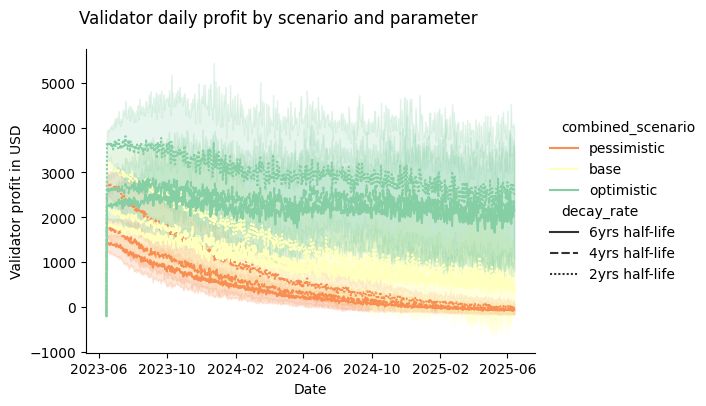

In [19]:
g = sns.relplot(data=vest_comb_df, x="date", y="validator_profit", style="decay_rate", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Validator profit in USD")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [20]:
vest_comb_df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean()

staking_scenario  decay_rate    
base              2yrs half-life    1502.030824
                  4yrs half-life    1106.827434
                  6yrs half-life     950.051595
optimistic        2yrs half-life    2987.911229
                  4yrs half-life    2420.759144
                  6yrs half-life    2191.740735
pessimistic       2yrs half-life     775.246211
                  4yrs half-life     471.117896
                  6yrs half-life     353.688059
Name: validator_profit, dtype: float64

In [21]:
vest_comb_df.groupby(["staking_scenario", "decay_rate"])["validator_profit"].mean().pct_change()

staking_scenario  decay_rate    
base              2yrs half-life         NaN
                  4yrs half-life   -0.263113
                  6yrs half-life   -0.141644
optimistic        2yrs half-life    2.144999
                  4yrs half-life   -0.189816
                  6yrs half-life   -0.094606
pessimistic       2yrs half-life   -0.646287
                  4yrs half-life   -0.392299
                  6yrs half-life   -0.249258
Name: validator_profit, dtype: float64

### 5.3 Inflation rates

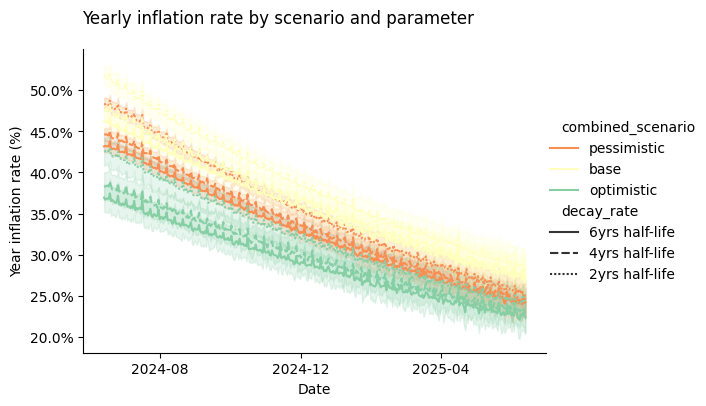

In [22]:
g = sns.relplot(data=vest_comb_df, x="date", y="year_inflation", style="decay_rate", hue="combined_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
g.set_axis_labels("Date", "Year inflation rate (%)")
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.25, 0.5])
plt.show()

In [23]:
vest_comb_df.groupby(["combined_scenario", "decay_rate"])["year_inflation"].mean()

combined_scenario  decay_rate    
base               2yrs half-life    0.385137
                   4yrs half-life    0.365532
                   6yrs half-life    0.356794
optimistic         2yrs half-life    0.321479
                   4yrs half-life    0.299704
                   6yrs half-life    0.289997
pessimistic        2yrs half-life    0.354662
                   4yrs half-life    0.335775
                   6yrs half-life    0.327542
Name: year_inflation, dtype: float64

## 6. Parameter analysis - release rate function

In [24]:
release_df = vest_df[vest_df["decay_rate"]=="4yrs half-life"]
release_comb_df = vest_comb_df[vest_comb_df["decay_rate"]=="4yrs half-life"]

### 6.1 Parameter space

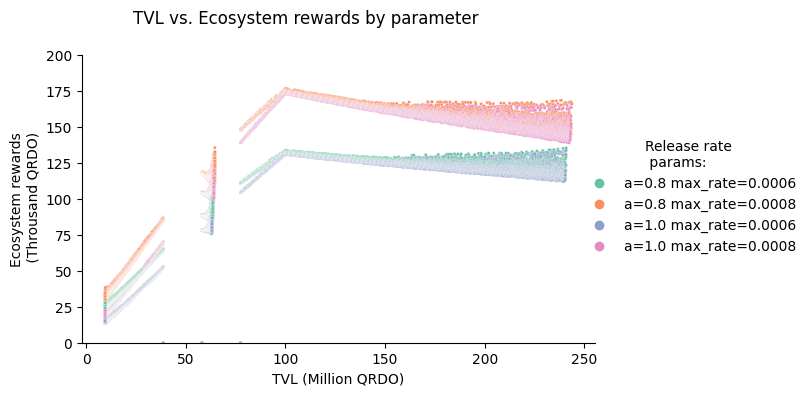

In [25]:
g = sns.relplot(data=release_comb_df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

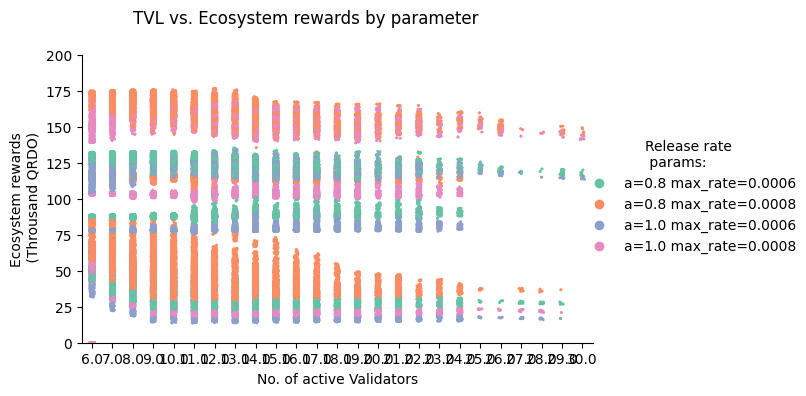

In [26]:
g = sns.catplot(data=release_comb_df, x="n_validators", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(0,200)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

### 6.2 Staker APR

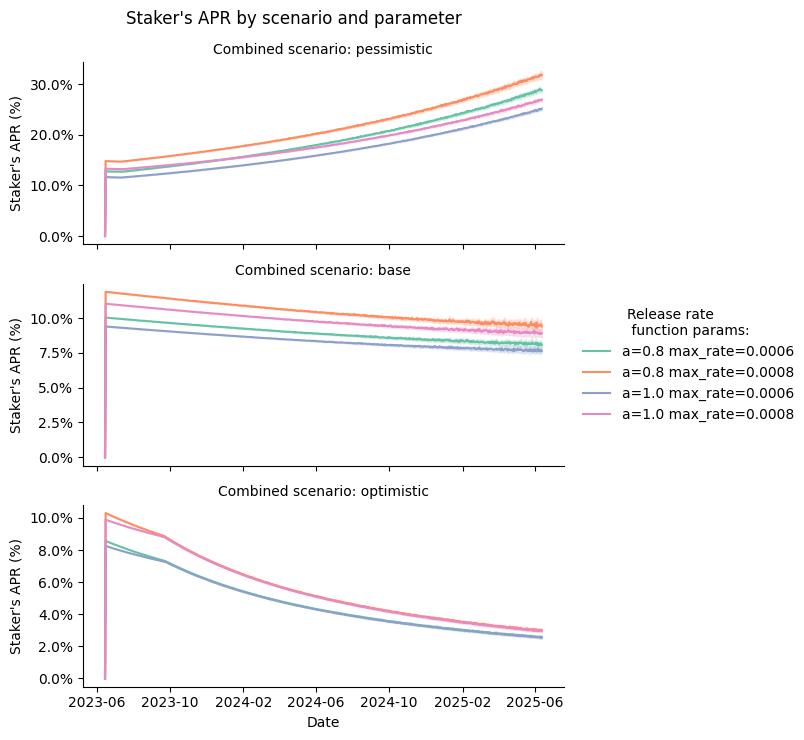

In [27]:
g = sns.relplot(data=release_comb_df, x="date", y="apr", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5, facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Staker's APR (%)")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[0][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[1][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[2][0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))

plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.35, 0.5])
plt.show()

In [28]:
release_comb_df.groupby(["combined_scenario", "release_rate_fn"])["apr"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    0.089180
                   a=0.8 max_rate=0.0008    0.104742
                   a=1.0 max_rate=0.0006    0.083711
                   a=1.0 max_rate=0.0008    0.097894
optimistic         a=0.8 max_rate=0.0006    0.047263
                   a=0.8 max_rate=0.0008    0.056234
                   a=1.0 max_rate=0.0006    0.046743
                   a=1.0 max_rate=0.0008    0.055576
pessimistic        a=0.8 max_rate=0.0006    0.190191
                   a=0.8 max_rate=0.0008    0.213262
                   a=1.0 max_rate=0.0006    0.167935
                   a=1.0 max_rate=0.0008    0.184295
Name: apr, dtype: float64

### 6.3 Validator Profit

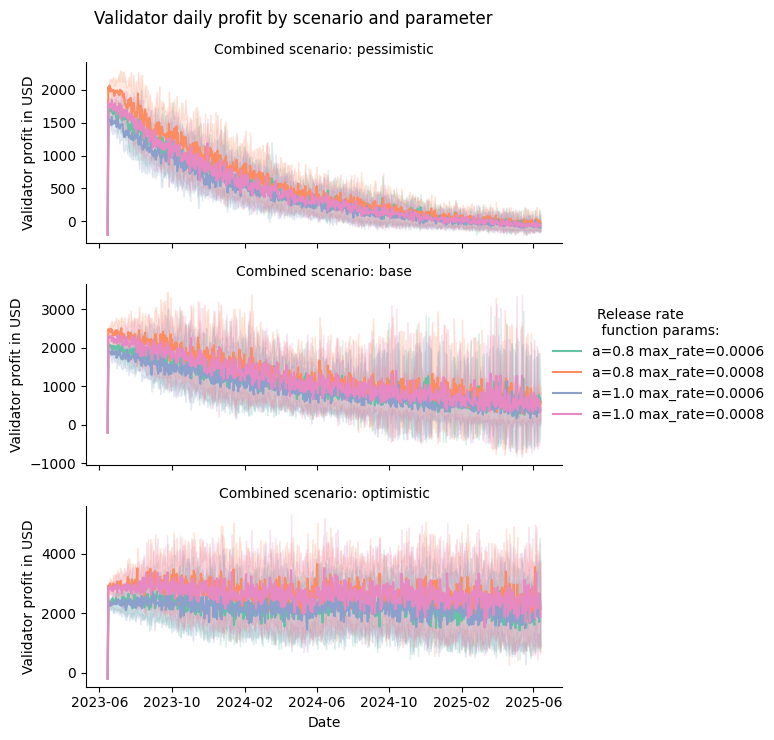

In [29]:
g = sns.relplot(data=release_comb_df, x="date", y="validator_profit", hue="release_rate_fn", row="combined_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=1.5,facet_kws={"sharey": False})
(g.set_axis_labels("Date", "Validator profit in USD")
  .set_titles("Combined scenario: {row_name}")
  ._legend.set_title('Release rate\n function params:')
)
g.axes[-1][-1].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Validator daily profit by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

In [30]:
release_comb_df.groupby(["combined_scenario", "release_rate_fn"])["validator_profit"].mean()

combined_scenario  release_rate_fn      
base               a=0.8 max_rate=0.0006    1043.143606
                   a=0.8 max_rate=0.0008    1260.562392
                   a=1.0 max_rate=0.0006     957.263926
                   a=1.0 max_rate=0.0008    1166.339813
optimistic         a=0.8 max_rate=0.0006    2201.768238
                   a=0.8 max_rate=0.0008    2676.255632
                   a=1.0 max_rate=0.0006    2170.920805
                   a=1.0 max_rate=0.0008    2634.091900
pessimistic        a=0.8 max_rate=0.0006     467.684964
                   a=0.8 max_rate=0.0008     560.323987
                   a=1.0 max_rate=0.0006     393.461217
                   a=1.0 max_rate=0.0008     463.001414
Name: validator_profit, dtype: float64